In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.models import Sersic2D, Gaussian2D
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [28]:
theta = np.radians(30.0)
sig2_X = 25.0
sig2_Y = 9.0
sig_X, sig_Y = sig2_X**0.5, sig2_Y**0.5
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
hogg_R = np.array(((sig_X*c, sig_Y*-s), (sig_X*s, sig_Y*c)))
diag = np.diag([sig2_X, sig2_Y])

In [31]:
import galsim

In [145]:
# gal object, sheared
s1, s2 = 5.0, 6.0
f1, f2 = 7.0, 3.0
e11, e12 = 0.3, 0.2
e21, e22 = 0.1, -0.8
dx1, dx2 = -10.0, -7.0
dy1, dy2 = 3.0, 13.0
gal1 = galsim.Gaussian(sigma=s1, flux=f1).shear(e1=e11, e2=e21).shift(dx=dx1, dy=dy1)
# another gal object, sheared
gal2 = galsim.Gaussian(sigma=s2, flux=f2).shear(e1=e12, e2=e22).shift(dx=dx2, dy=dy2)

total = gal1 + gal2

In [160]:
scale = 0.4
img = total.drawImage(nx=256, ny=256, scale=scale)

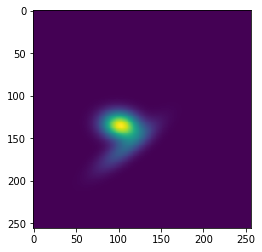

In [161]:
plt.imshow(img.array)

In [162]:
print("first moments")
r1 = f1/(f1 + f2)
r2 = f2/(f1 + f2)
Ix = r1*dx1 + r2*dx2
Iy = r1*dy1 + r2*dy2
print(Ix, Iy)

first moments
(-9.1, 6.0)


In [172]:
print("second moments")
def get_second_moments(sig, e1, e2):
    theta = 0.5*np.arctan(e2/e1)
    e = (e1**2.0 + e2**2.0)**0.5
    q = ((1.0 - e)/(1.0 + e))**0.5
    lam1 = sig**2.0/q
    lam2 = sig**2.0*q
    cos = np.cos(theta)
    sin = np.sin(theta)
    Ixx = lam1*cos**2.0 + lam2*sin**2.0
    Iyy = lam1*sin**2.0 + lam2*cos**2.0
    Ixy = (lam1 - lam2)*cos*sin
    return Ixx, Ixy, Iyy

Ixx1, Ixy1, Iyy1 = get_second_moments(s1, e11, e21)
Ixx2, Ixy2, Iyy2 = get_second_moments(s2, e12, e22)

Ixx = r1*(Ixx1 + (dx1 - Ix)**2.0) + r2*(Ixx2 + (dx2 - Ix)**2.0)
Iyy = r1*(Iyy1 + (dy1 - Iy)**2.0) + r2*(Iyy2 + (dy2 - Iy)**2.0)
Ixy = r1*(Ixy1 + (dx1 - Ix)*(dy1 - Iy)) + r2*(Ixy2 + (dx2 - Ix)*(dy2 - Iy))

print(Ixx, Ixy, Iyy)

second moments
(48.78086530005436, -7.128844505197877, 49.186140252650304)


In [173]:
import os, sys
sys.path.insert(0, '../utils')
from utils import *
get_first_moments_from_image(image_array=img.array, pixel_scale=scale)

(-9.10001416893429, 6.000001953625051)

In [174]:
get_second_moments_from_image(image_array=img.array, pixel_scale=scale)


(48.79452298883785, -7.129226021483541, 49.1987850858689)

In [152]:
R, hogg_R

(array([[ 0.8660254, -0.5      ],
        [ 0.5      ,  0.8660254]]), array([[ 4.33012702, -1.5       ],
        [ 2.5       ,  2.59807621]]))

In [153]:
Sig_prime = np.dot(np.dot(R, diag), R.T)

In [11]:
Sig_prime

array([[21.        ,  6.92820323],
       [ 6.92820323, 13.        ]])

In [20]:
rho = (sig2_X - sig2_Y)*c*s / ((sig2_X*c**2.0 + sig2_Y*s**2.0)*(sig2_X*s**2.0 + sig2_Y*c**2.0))**0.5

In [21]:
rho

0.41931393468876726

In [30]:
np.dot(np.dot(hogg_R, np.diag([15.0, 15.0])), hogg_R.T)

array([[315.        , 103.92304845],
       [103.92304845, 195.        ]])

# Expressing a 2D Sersic profile as a Mixture of Gaussians (MoG)

Author: Ji Won Park (jiwoncpark)

Many survey catalogs model the galaxy bulge as a de Vaucouleurs profile and the galaxy disk as an exponential profile. These profiles belong to the more general class of *Sersic profiles* indexed by $n$, which controls the profile's degree of curvature, or how fast the intensity falls off from the center. The de Vaucouleurs profile is the case when $n=4$ and exponential, $n=1$.

The Sersic distribution is commonly expressed as:
$I(r) = I_e \exp(-b_n [(r/r_0)^{1/n} - 1])$, where $b_n$ can be obtained by numerically solving $\Gamma(2 n) = 2\gamma(b_n, 2n)$ and the intensity equals $I_e$ at the half-light radius $r_0$.

In this tutorial, we use [Hogg and Lang 2013](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1210.6563) (HL13) to approximate this as a mixture, i.e. a linear superposition, of Gaussian distributions. Doing this allows SLRealizer to take advantage of all that Gaussians have to offer--for instance, we can simplify the PSF convolution using the fact that convolving a Gaussian with a Gaussian yields another Gaussian.

Let's first get the values of $b_4$ and $b_1$.

In [4]:
from scipy.special import gammaincinv
b4 = gammaincinv(8, 0.5) # for de vaucouleurs
b1 = gammaincinv(2, 0.5) # for exponential

print(b4, b1)

(7.669249442500805, 1.6783469900166612)


## 1. de Vaucouleurs ~ MoG

Performing a change of variable and some scaling on the HL13 formulation, we have that the following de Vaucouleurs distribution

$I_4(r) = \frac{1}{C_4} \exp(-b_1[(r/r_0)^{1/4} - 1])$ can be approximated by

$\tilde{I}_4(r) = \frac{r_0^2}{C_4} \sum_{m=1}^{M_1} c_m N(r ; 0, v_m r_0^2 I) $ where

$C_4 = \frac{40320 \pi r_0^2 e^{b_4}}{b_4^8}$ is a normalization constant to ensure both $I_4$ and $\tilde{I}_4$ integrate to unity.

The optimal fit values for the variances $v_m$ and the weights $c_m$ for a given mixture size $M_4$ are listed in Table 1 of HL13. We use $M_4 = 6$, the smallest mixture size listed, and the corresponding $\sqrt{v_m}$ and $c_m$ values can be found in the cell below.

In [69]:
20160.0*np.exp(b4)*2.0*np.pi/(b4**8.0)

22.665233723581746

In [76]:
dev_mog_params = {}
dev_mog_params['stds'] = np.array([0.00087, 0.00296, 0.00792, 0.01902, 0.04289, 0.09351, 0.20168, 0.44126, 1.01833, 2.74555]) # sqrt(v_m)
dev_mog_params['weights'] = np.array([0.00139, 0.00941, 0.04441, 0.16162, 0.48121, 1.20357, 2.54182, 4.46441, 6.22821, 6.15393]) # c_m

### 1.1 Test of Flux
In all tests to follow, we put $r_0=1.3$. Let's check that the flux of $\tilde{I}_4$ equals 1.

In [77]:
np.sum(dev_mog_params['weights'])/C4

0.5558125477730289

In [78]:
r0 = 1.3

# Compare zeroth moments (flux)
C4 = 40320.0*np.pi*r0**2.0*np.exp(b4)/b4**8.0 # i.e. C4 found by analytically integrating $I_4$
dev_mog_flux = np.sum(dev_mog_params['weights'])*r0**2.0/C4
print(dev_mog_flux)

0.939323205736419


### 1.2 Test of Second Moment
Note that all odd moments will be zero, since our profiles are circularly symmetric. We obtain the second moment (either diagonal entry of the second-moment matrix) of $I_1$ analytically and compare it with the that of $\tilde{I}_1$, which is the weighted sum of the second moments of its components, i.e. $\frac{r_0^2}{C_4} \sum_{m=1}^{M_4} c_m (v_m r_0^2) $.

In [17]:
# Original exponential
dev_2nd_mom = np.pi*5230697472000.0*np.exp(b4)*r0**4.0/(b4**16.0)/C4 # analytically derived
#TODO: this is wrong, based on numerical second moment estimation from image grid

# MoG
dev_mog_2nd_mom = np.sum(dev_mog_params['weights']*dev_mog_params['stds']**2.0)*r0**4.0/C4
print(dev_2nd_mom, dev_mog_2nd_mom)

(0.9755705485839006, 0.06261895663865294)


### 1.3 Sanity Check Using Images

In [59]:
center = 0.0
pixel_scale = 0.001

x,y = np.meshgrid(np.arange(-8.0, 8.0, pixel_scale), np.arange(-8.0, 8.0, pixel_scale)) # must extend out to 8 from center

In [60]:
def dev_hl13(x, y):
    return 1.0/C4*np.exp(-b4*((np.sqrt(x**2.0 + y**2.0)/r0)**0.25 - 1.0))

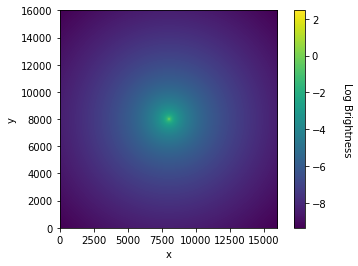

In [61]:
dev_hl13_img = dev_hl13(x, y)

plt.figure()
plt.imshow(np.log(dev_hl13_img), origin='lower', interpolation='nearest')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
#cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

In [62]:
np.sum(dev_hl13_img), dev_hl13_img.shape, C4

(432730.3625942615, (16000, 16000), 181.32186978865397)

In [55]:
dev_astropy = Sersic2D(amplitude=1.0/C4, r_eff=r0, n=4, x_0=center, y_0=center, ellip=0.0, theta=0.0)
dev_astropy_img = dev_astropy(x, y)
#np.save('dev_astropy_img', dev_astropy_img)
#np.save('dev_hl13_img', dev_hl13_img)

In [57]:
np.sum(dev_astropy_img)

498797.08369291265

In [199]:
assert np.allclose(dev_astropy_img, dev_hl13_img)
#assert np.isclose(np.sum(dev_hl13_img)*4.0*pixel_scale**2.0, 1.0, rtol=1.e-3)
assert dev_hl13(r0, 0.0) == 1.0/C4
assert dev_astropy(r0, 0.0) == 1.0/C4
np.max(dev_hl13_img), 1.0/C4*np.exp(b4)

(374.88106555941556, 377.9309878735809)

In [ ]:
%%time
dev_mog_img = None
for weight, std in list(zip(dev_mog_params['weights'], dev_mog_params['stds'])):
    approx = Gaussian2D(amplitude=weight/(2.0*np.pi*(std)**2.0), x_mean=center, y_mean=center, x_stddev=std*r0, y_stddev=std*r0)
    if dev_mog_img is None:
        dev_mog_img = approx(x, y)
    else:
        dev_mog_img += approx(x, y)

dev_mog_img /= C4
np.save('dev_mog_img.txt', dev_mog_img)

plt.figure()
plt.imshow(np.log(dev_mog_img), origin='lower', interpolation='nearest')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
#cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

In [ ]:
dev_residual = (dev_mog_img - dev_hl13_img)/dev_hl13_img
plt.imshow(dev_residual, origin='lower', interpolation='nearest')
plt.colorbar()

The average discrepancy per pixel is around 76%.

In [ ]:
np.mean(dev_residual)

## 2. Exponential ~ MoG

Performing a change of variable and some scaling on the HL13 formulation, we have that the following exponential distribution

$I_1(r) = \frac{1}{C_1} \exp(-b_1[r/r_0 - 1])$ can be approximated by

$\tilde{I}_1(r) = \frac{r_0^2}{C_1} \sum_{m=1}^{M_1} c_m N(r ; 0, v_m r_0^2 I) $ where

$C_1 = \frac{2 \pi r_0^2 e^{b_1}}{b_1^2}$ is a normalization constant to ensure both $I_1$ and $\tilde{I}_1$ integrate to unity.

The optimal fit values for the variances $v_m$ and the weights $c_m$ for a given mixture size $M_1$ are listed in Table 1 of HL13. We use $M_1 = 4$, the smallest mixture size listed, and the corresponding $\sqrt{v_m}$ and $c_m$ values can be found in the cell below.

In [80]:
exp_mog_params = {}
exp_mog_params['stds'] = np.array([0.12068, 0.32730, 0.68542, 1.28089]) # sqrt(v_m)
exp_mog_params['weights'] = np.array([0.09733, 1.12804, 4.99846, 5.63632]) # c_m

In [81]:
C1/r0**2.0

NameError: name 'C1' is not defined

### 2.1 Test of Flux
In all tests to follow, we put $r_0=1.3$. Let's check that the flux of $\tilde{I}_1$ equals 1.

In [82]:
r0 = 1.3

# Compare zeroth moments (flux)
C1 = 2.0*np.pi*r0**2.0*np.exp(b1)/b1**2.0 # i.e. C1 found by analytically integrating $I_1$
exp_mog_flux = np.sum(exp_mog_params['weights'])*r0**2.0/C1
print(exp_mog_flux)

0.99260620326028


### 2.2 Test of Second Moment
We obtain the second moment (either diagonal entry of the second-moment matrix) of $I_1$ analytically and compare it with the that of $\tilde{I}_1$, which is the weighted sum of the second moments of its components, i.e. $\frac{r_0^2}{C_1} \sum_{m=1}^{M_1} c_m (v_m r_0^2) $.

In [ ]:
# Original exponential
exp_2nd_mom = np.pi*6.0*np.exp(b1)*r0**4.0/(b1**4.0)/C1 # analytically derived

# MoG
exp_mog_2nd_mom = np.sum(exp_mog_params['weights']*exp_mog_params['stds']**2.0)*r0**4.0/C1
print(exp_2nd_mom, exp_mog_2nd_mom)

### 2.3 Sanity Check Using Images

In [ ]:
center = 0.0
pixel_scale = 0.001
x,y = np.meshgrid(np.arange(0.0, 8.0, pixel_scale), np.arange(0.0, 8.0, pixel_scale)) # must extend out to 8 from center

In [ ]:
def exp_hl13(x, y):
    return 1.0/C1*np.exp(-b1*(np.sqrt(x**2.0 + y**2.0)/r0 - 1.0))

In [ ]:
exp_astropy = Sersic2D(amplitude=1.0/C1, r_eff=r0, n=1, x_0=center, y_0=center, ellip=0.0, theta=0.0)
exp_hl13_img = exp_hl13(x, y)

plt.figure()
plt.imshow(exp_hl13_img, origin='lower', interpolation='nearest')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Brightness', rotation=270, labelpad=25)
#cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

In [ ]:
exp_astropy_img = exp_astropy(x, y)
np.save('exp_astropy_img', exp_astropy_img)
np.save('exp_hl13_img', exp_hl13_img)

In [ ]:
assert np.allclose(exp_astropy_img, exp_hl13_img)
assert np.isclose(np.sum(exp_hl13_img)*4.0*pixel_scale**2.0, 1.0, rtol=1.e-3)
assert exp_hl13(r0, 0.0) == 1.0/C1
assert np.max(exp_hl13_img) == 1.0/C1*np.exp(b1)

In [ ]:
%%time
exp_mog_img = None
for weight, std in list(zip(exp_mog_params['weights'], exp_mog_params['stds'])):
    approx = Gaussian2D(amplitude=weight/(2.0*np.pi*(std)**2.0), x_mean=center, y_mean=center, x_stddev=std*r0, y_stddev=std*r0)
    if exp_mog_img is None:
        exp_mog_img = approx(x, y)
    else:
        exp_mog_img += approx(x, y)

exp_mog_img /= C1
np.save('exp_mog_img.txt', exp_mog_img)

plt.figure()
plt.imshow(exp_mog_img, origin='lower', interpolation='nearest')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Brightness', rotation=270, labelpad=25)
#cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

In [ ]:
exp_residual = (exp_mog_img - exp_hl13_img)/exp_hl13_img
plt.imshow(exp_residual, origin='lower', interpolation='nearest')
plt.colorbar()

The average discrepancy per pixel is around 58%.

In [ ]:
np.mean(exp_residual)